In [423]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# metrics
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error

# model building
from tensorflow.keras import Sequential
from tensorflow.keras import layers
from tensorflow.keras.layers import Masking
from tensorflow.keras.metrics import RootMeanSquaredError
from keras.models import Sequential
from keras.layers import Dense, SimpleRNN, Flatten
from tensorflow.keras.layers import SimpleRNN, LSTM, GRU, Dropout
from keras import layers
from tensorflow.keras import callbacks
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import KFold

# URL Download
import csv
import io
import urllib.request
import requests

# Read in data

In [424]:
!pwd

/home/jakob/code/hmichinaka/berlin-bike-theft-forecasting/notebooks


In [425]:
df_feat = pd.read_csv("../raw_data/daily_features_theft.csv")

In [426]:
df_feat.columns

Index(['Unnamed: 0', 'date', 'min_temp', 'max_temp', 'the_temp',
       'weather_state_name', 'weather_state_abbr', 'wind_speed',
       'wind_direction', 'air_pressure', 'humidity', 'visibility',
       'daylight_hours', 'isholidays', 'weekday', 'weeknum'],
      dtype='object')

In [427]:
df_feat.drop(columns = 'Unnamed: 0', inplace=True )

In [428]:
df_feat.head()

,date,min_temp,max_temp,the_temp,weather_state_name,weather_state_abbr,wind_speed,wind_direction,air_pressure,humidity,visibility,daylight_hours,isholidays,weekday,weeknum
0,2021-01-01,0.005,2.395,2.070,Sleet,sl,3.020726,227.616640,1007.0,93,6.031650,07:50:24,1,4,53
1,2021-01-02,-1.135,3.045,2.465,Heavy Cloud,hc,2.666541,193.699868,1015.0,89,12.863316,07:51:41,0,5,53
2,2021-01-03,-1.315,1.955,0.985,Snow,sn,9.161659,55.677273,1015.0,96,2.144352,07:53:05,0,6,53
3,2021-01-04,0.030,1.780,1.355,Sleet,sl,6.271227,54.331796,1017.0,96,2.927901,07:54:33,0,0,1
4,2021-01-05,-0.030,2.730,1.270,Light Rain,lr,6.009528,26.500356,1017.0,94,7.021805,07:56:08,0,1,1


In [429]:
df_theft = pd.read_csv("../raw_data/bike_theft_cleaned.csv")

In [430]:
df_theft.head()

,Unnamed: 0,date_reported,date_theft_start,hour_theft_start,date_theft_end,hour_theft_end,LOR,estimated_value,attempt,type_bike,theft_type,theft_type_detail,datetime_theft_start,datetime_theft_end,Timedelta_theft_end_start,datetime_theft_mean,BZR,PGR,Bezirk
0,0,2022-02-28,2022-02-26,14:00:00,2022-02-26,14:00:00,7100103,580.0,No,bike,Fahrraddiebstahl,Sonstiger schwerer Diebstahl von Fahrrädern,2022-02-26 14:00:00,2022-02-26 14:00:00,0.0,2022-02-26 14:00:00,71001,710,7
1,1,2022-02-28,2022-02-28,16:00:00,2022-02-28,16:00:00,2100106,0.0,No,man's bike,Fahrraddiebstahl,Sonstiger schwerer Diebstahl von Fahrrädern,2022-02-28 16:00:00,2022-02-28 16:00:00,0.0,2022-02-28 16:00:00,21001,210,2
2,2,2022-02-28,2022-02-28,20:00:00,2022-02-28,20:00:00,8300935,0.0,No,other bike,Fahrraddiebstahl,Einfacher Diebstahl von Fahrrädern,2022-02-28 20:00:00,2022-02-28 20:00:00,0.0,2022-02-28 20:00:00,83009,830,8
3,3,2022-02-28,2022-02-28,8:00:00,2022-02-28,8:00:00,4400727,1000.0,No,other bike,Fahrraddiebstahl,Sonstiger schwerer Diebstahl von Fahrrädern,2022-02-28 08:00:00,2022-02-28 08:00:00,0.0,2022-02-28 08:00:00,44007,440,4
4,4,2022-02-28,2022-02-25,5:00:00,2022-02-25,17:00:00,9100305,499.0,No,man's bike,Fahrraddiebstahl,Sonstiger schwerer Diebstahl von Fahrrädern,2022-02-25 05:00:00,2022-02-25 17:00:00,12.0,2022-02-25 11:00:00,91003,910,9


# Combine datasets

## Group theft data by Bezirk and date

In [431]:
# Group dataframe by date and LOR
df_theft = df_theft.pivot_table(index = "date_theft_start", columns = "Bezirk", values = "type_bike", aggfunc= "count")

df_theft.fillna(value = 0, inplace=True)

In [432]:
# create "total" column which sums up data for each day
df_theft["total"] = df_theft.sum(axis=1)


df_theft.shape

(424, 13)

In [433]:
df_feat.columns

Index(['date', 'min_temp', 'max_temp', 'the_temp', 'weather_state_name',
       'weather_state_abbr', 'wind_speed', 'wind_direction', 'air_pressure',
       'humidity', 'visibility', 'daylight_hours', 'isholidays', 'weekday',
       'weeknum'],
      dtype='object')

In [434]:
df_theft.columns

Index([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 'total'], dtype='object', name='Bezirk')

## Merge datasets

We merge the "total" column from the theft dataset with the features from the features dataset

In [435]:
# First we have to reset the index in the df_theft to create a column to merge on 

df_theft.reset_index( inplace=True)

In [436]:
# as the last step we rename the date column to match the name in df_feat
df_theft = df_theft.rename(columns={"date_theft_start": "date"})

In [437]:
df_feat.columns

Index(['date', 'min_temp', 'max_temp', 'the_temp', 'weather_state_name',
       'weather_state_abbr', 'wind_speed', 'wind_direction', 'air_pressure',
       'humidity', 'visibility', 'daylight_hours', 'isholidays', 'weekday',
       'weeknum'],
      dtype='object')

In [438]:
df_theft.columns

Index(['date', 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 'total'], dtype='object', name='Bezirk')

In [439]:
!pwd

/home/jakob/code/hmichinaka/berlin-bike-theft-forecasting/notebooks


In [440]:
df_theft[["date", "total"]].to_csv("../bike_theft_total_daily.csv")

In [441]:
# combine the datasets
df_combined = pd.merge(df_feat, df_theft, on = "date")

In [442]:
df_combined.head()

,date,min_temp,max_temp,the_temp,weather_state_name,weather_state_abbr,wind_speed,wind_direction,air_pressure,humidity,...,4,5,6,7,8,9,10,11,12,total
0,2021-01-01,0.005,2.395,2.070,Sleet,sl,3.020726,227.616640,1007.0,93,...,4.0,1.0,0.0,0.0,1.0,1.0,2.0,1.0,0.0,16.0
1,2021-01-02,-1.135,3.045,2.465,Heavy Cloud,hc,2.666541,193.699868,1015.0,89,...,3.0,0.0,1.0,1.0,2.0,2.0,0.0,1.0,1.0,16.0
2,2021-01-03,-1.315,1.955,0.985,Snow,sn,9.161659,55.677273,1015.0,96,...,2.0,0.0,2.0,3.0,0.0,2.0,3.0,0.0,0.0,17.0
3,2021-01-04,0.030,1.780,1.355,Sleet,sl,6.271227,54.331796,1017.0,96,...,4.0,0.0,2.0,4.0,3.0,1.0,0.0,1.0,2.0,33.0
4,2021-01-05,-0.030,2.730,1.270,Light Rain,lr,6.009528,26.500356,1017.0,94,...,5.0,2.0,1.0,5.0,0.0,4.0,0.0,0.0,1.0,29.0


## Select relevant features

In [443]:
df_combined.columns

Index([              'date',           'min_temp',           'max_temp',
                 'the_temp', 'weather_state_name', 'weather_state_abbr',
               'wind_speed',     'wind_direction',       'air_pressure',
                 'humidity',         'visibility',     'daylight_hours',
               'isholidays',            'weekday',            'weeknum',
                          1,                    2,                    3,
                          4,                    5,                    6,
                          7,                    8,                    9,
                         10,                   11,                   12,
                    'total'],
      dtype='object')

- For now we will drop the Bezirke columns, and the weather_state_name as well as weather_state_abbr
- We will also drop min_temp and max_temp and just keep the_temp 
- We will further drop wind_direction

In [444]:
cols_select = ["date", "the_temp", "wind_speed", "air_pressure", "humidity", "visibility", 
              "daylight_hours", "isholidays", "weekday", "weeknum", 
              "total"]

In [445]:
df_combined = df_combined[cols_select]

In [446]:
df_combined.head()

,date,the_temp,wind_speed,air_pressure,humidity,visibility,daylight_hours,isholidays,weekday,weeknum,total
0,2021-01-01,2.070,3.020726,1007.0,93,6.031650,07:50:24,1,4,53,16.0
1,2021-01-02,2.465,2.666541,1015.0,89,12.863316,07:51:41,0,5,53,16.0
2,2021-01-03,0.985,9.161659,1015.0,96,2.144352,07:53:05,0,6,53,17.0
3,2021-01-04,1.355,6.271227,1017.0,96,2.927901,07:54:33,0,0,1,33.0
4,2021-01-05,1.270,6.009528,1017.0,94,7.021805,07:56:08,0,1,1,29.0


In [447]:
df_combined = df_combined.set_index("date")

In [448]:
# Change dtype of daylight_hours from object to float
# first calculate seconds
df_combined["daylight_hours"] = df_combined["daylight_hours"].apply(lambda x: sum(int(x) * 60 ** i for i, x in enumerate(reversed(x.split(':')))))

In [449]:
# then calculate hours as float from the seconds
df_combined["daylight_hours"] = df_combined["daylight_hours"]/3600

In [450]:
df_combined.dtypes

the_temp          float64
wind_speed        float64
air_pressure      float64
humidity            int64
visibility        float64
daylight_hours    float64
isholidays          int64
weekday             int64
weeknum             int64
total             float64
dtype: object

# Train-test-split

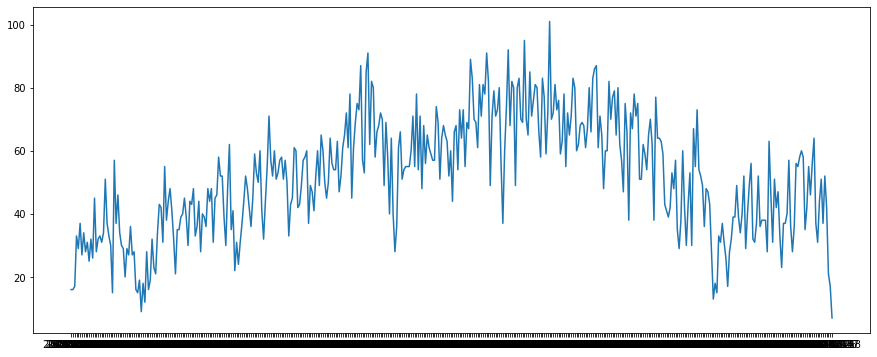

In [451]:
plt.figure(figsize = (15, 6))
plt.plot(df_combined["total"]);

In [452]:
df_combined["total"].mean()

51.62971698113208

In [453]:
df_combined["total"].std()

18.194955888318802

In [454]:
int(len(df_combined) * 0.8)

339

In [455]:
def get_X_y(window_size, future_horizon, dataset):

  X = []
  y = []

  for i in range(0, dataset.shape[0] - window_size - future_horizon):
    X.append(dataset.iloc[i: i + window_size])
    y.append(dataset["total"][i + window_size : i + window_size  + future_horizon, ])

  return np.array(X), np.array(y)

In [456]:
window_size = 31
future_horizon = 1

X_train, y_train = get_X_y(window_size,future_horizon, df_combined.iloc[:339, :])
X_test, y_test = get_X_y(window_size, future_horizon, df_combined.iloc[339:, :])

In [457]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((307, 31, 10), (307, 1), (53, 31, 10), (53, 1))

In [458]:
X_train[0][0]

array([2.07000000e+00, 3.02072617e+00, 1.00700000e+03, 9.30000000e+01,
       6.03165016e+00, 7.84000000e+00, 1.00000000e+00, 4.00000000e+00,
       5.30000000e+01, 1.60000000e+01])

# KFold Cross validation

In [464]:
def model_cross_validation(model, X_train, y_train):
    """
    input: model before compilation, training and test vectors
    compiles the model, fits and evaluates on 5 folds
    outputs: for each fold the loss and MAPE"""
    model.compile(loss = "mse",
                 optimizer = "adam",
                 metrics = "mean_absolute_percentage_error")
    
    es = callbacks.EarlyStopping(patience = 5, restore_best_weights=True)
    results = []
    kf = KFold(n_splits = 5)
    kf.get_n_splits(X_train)

    for train_index, test_index in kf.split(X_train):

        # split the data into train and test set
        X_train_cv = X_train[train_index]
        X_test_cv = X_train[test_index]
        y_train_cv = y_train[train_index]
        y_test_cv = y_train[test_index]

        model = model 
        
        # Fit the model
        model.fit(X_train_cv, 
                  y_train_cv, 
                  batch_size = 16, 
                  epochs = 300, 
                  verbose = 0, 
                  callbacks = [es], 
                  validation_split = 0.2)
        
        # Evaluate the model on the test data
        results.append(model.evaluate(X_test_cv, y_test_cv))
        
    return results

# Modelling

## One-dense-layer model

In [465]:
base_model = Sequential([
    Flatten(input_shape=X_train.shape[1:]),
    Dense(1)
])
base_model_cv_results = model_cross_validation(base_model, X_train, y_train)

2/2 [==============================] - 0s 2ms/step - loss: 242.7174 - mean_absolute_percentage_error: 21.6249


In [467]:
np.mean(base_model_cv_results, axis = 0)[1]

53.003868865966794

In [462]:
es = callbacks.EarlyStopping(patience = 5, restore_best_weights=True)

In [41]:
base_model = Sequential([
    Flatten(input_shape=X_train.shape[1:]),
    Dense(1)
])

base_model.compile(loss = "mse",
                 optimizer = "adam",
                 metrics = "mean_absolute_percentage_error")


base_model.fit(X_train, 
                  y_train, 
                  batch_size = 16, 
                  epochs = 300, 
                  verbose = 0, 
                  callbacks = [es], 
                  validation_split = 0.2)

In [42]:
base_model.evaluate(X_test, y_test)

2/2 [==============================] - 0s 2ms/step - loss: 304.1122 - mean_absolute_percentage_error: 37.3524


[304.1121826171875, 37.352420806884766]

## Finetuned model

In [401]:
def create_opt_model(): 
    """
    Creates the finetuned model selected in B_Theft_Modelling
    Outputs models, that needs to be compiled and fit"""
    model = Sequential()
    # first LSTM layer
    model.add(LSTM(units = 70, activation = "tanh", return_sequences = True))
    model.add(Dropout(0.2))
    # second LSTM layer
    model.add(LSTM(units= 30, activation= "tanh", return_sequences= False))
    model.add(Dropout(0.2))

    # output layer to predict one value
    model.add(Dense(1, activation= "linear"))
    return model

In [44]:
opt_model_cv_results = model_cross_validation(create_opt_model())

2/2 [==============================] - 0s 8ms/step - loss: 174.9709 - mean_absolute_percentage_error: 17.9854


In [45]:
np.mean(opt_model_cv_results, axis = 0)

array([319.62936401,  36.54433212])

In [46]:
opt_model = create_opt_model()
opt_model.compile(optimizer= "adam", loss= "mse", metrics = "mean_absolute_percentage_error")
opt_model.fit(X_train, 
                  y_train, 
                  batch_size = 8, 
                  epochs = 300, 
                  verbose = 0, 
                  callbacks = [es], 
                  validation_split = 0.2)

In [47]:
opt_model.evaluate(X_test, y_test)

2/2 [==============================] - 0s 8ms/step - loss: 355.1870 - mean_absolute_percentage_error: 48.3023


[355.1869812011719, 48.302330017089844]

# Rolling average

## Calculate rolling average

In [258]:
def calculate_rolling_average(df, window_size):
    fill_value = df["total"][-window_size:].mean()
    df["total_moving_average"] = df["total"].rolling(window = window_size, center = True).mean().fillna(fill_value)
    return df

In [260]:
df_combined = calculate_rolling_average(df_combined, 3)

In [261]:
df_combined.tail()

,the_temp,wind_speed,air_pressure,humidity,visibility,daylight_hours,isholidays,weekday,weeknum,total,total_moving_average
date,,,,,,,,,,,
2022-02-24,9.210,9.855780,1011.5,67,14.118175,38132,0,3,8,52.0,43.666667
2022-02-25,6.305,11.460817,1016.0,64,10.139846,38374,0,4,8,42.0,38.333333
2022-02-26,5.950,6.208894,1032.0,77,11.720303,38615,0,5,8,21.0,26.666667
2022-02-27,6.175,3.942383,1037.5,72,12.481172,38858,0,6,8,17.0,15.000000
2022-02-28,4.985,5.008762,1036.0,57,14.556242,39101,0,0,9,7.0,15.000000


## Feed into model

In [262]:
# For now we only take the total and total_moving_average into account
df_ma = df_combined[["total", "total_moving_average"]]

In [263]:
df_ma = df_combined.drop(columns = ["the_temp", "wind_speed", "air_pressure", "humidity", "visibility", "daylight_hours", 
                                   "isholidays", "weekday", "weeknum"])

In [264]:
df_ma.dtypes

total                   float64
total_moving_average    float64
dtype: object

In [265]:
# Train-test-split
int(len(df_ma)* 0.8)

339

In [266]:
window_size = 31
future_horizon = 1

X_train, y_train = get_X_y(window_size,future_horizon, df_ma.iloc[:339, :])
X_test, y_test = get_X_y(window_size, future_horizon, df_ma.iloc[339:, :])

In [56]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((307, 31, 2), (307, 1), (53, 31, 2), (53, 1))

In [57]:
opt_model_cv_results = model_cross_validation(create_opt_model())

2/2 [==============================] - 0s 7ms/step - loss: 45.9434 - mean_absolute_percentage_error: 7.1394


In [58]:
np.mean(opt_model_cv_results, axis = 0)[1]

21.717522716522218

In [59]:
X_train.shape

(307, 31, 2)

In [60]:
opt_model = create_opt_model()
opt_model.compile(optimizer= "adam", loss= "mse", metrics = "mean_absolute_percentage_error")
opt_model.fit(X_train, 
                  y_train, 
                  batch_size = 8, 
                  epochs = 300, 
                  verbose = 0, 
                  callbacks = [es], 
                  validation_split = 0.2)

In [61]:
opt_model.evaluate(X_test, y_test)

2/2 [==============================] - 0s 7ms/step - loss: 4.5685 - mean_absolute_percentage_error: 4.1406


[4.56851863861084, 4.140583038330078]

In [62]:
# Moving average window size = 7
# Result for not-centered moving average: Evaluation on the test set: mean_absolute_percentage_error: 24.9789
#  filled NAs with mean of days 7-14
# Result for centered moving average: Evaluation on the test set: mean_absolute_percentage_error: 17.9939
#  filled NAs with mean of last seven observations of whole dataset

# Moving average window size = 5
# Result for centered moving average: Evaluation on the test set: mean_absolute_percentage_error: 9.5739
# filled NAs with mean of last five observations

# Moving average window size = 3
# Result for centered moving average: Evaluation on the test set: mean_absolute_percentage_error: 4.4171
# filled NAs with mean of last three observations

# Moving average window size = 1
# Result for centered moving average: Evaluation on the test set: mean_absolute_percentage_error: 26.0934
# filled NAs with mean of last observation

In [63]:
df_combined.tail()

,the_temp,wind_speed,air_pressure,humidity,visibility,daylight_hours,isholidays,weekday,weeknum,total,total_moving_average
date,,,,,,,,,,,
2022-02-24,9.210,9.855780,1011.5,67,14.118175,10.592222,0,3,8,52.0,43.666667
2022-02-25,6.305,11.460817,1016.0,64,10.139846,10.659444,0,4,8,42.0,38.333333
2022-02-26,5.950,6.208894,1032.0,77,11.720303,10.726389,0,5,8,21.0,26.666667
2022-02-27,6.175,3.942383,1037.5,72,12.481172,10.793889,0,6,8,17.0,15.000000
2022-02-28,4.985,5.008762,1036.0,57,14.556242,10.861389,0,0,9,7.0,21.000000


In [64]:
df_ma.tail()

,total,total_moving_average
date,,
2022-02-24,52.0,43.666667
2022-02-25,42.0,38.333333
2022-02-26,21.0,26.666667
2022-02-27,17.0,15.000000
2022-02-28,7.0,21.000000


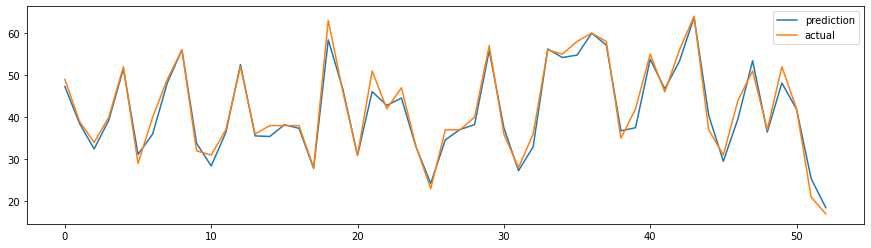

In [65]:
plt.figure(figsize= (15, 4))
plt.plot(opt_model.predict(X_test), label = "prediction")
plt.plot(y_test, label = "actual")
plt.legend();

# Cutoff the last 3 days for the prediction

## Create test and train arrays

We create the X and y vectors from the df_ma dataset but leave out the last three days. 

In [135]:
int((len(df_ma[:-3])) * 0.8)

336

In [136]:
window_size = 31
future_horizon = 1

X_train_cut, y_train_cut = get_X_y(window_size,future_horizon, df_ma.iloc[:336, :])
X_test_cut, y_test_cut = get_X_y(window_size, future_horizon, df_ma.iloc[336:-3, :])

In [137]:
X_train_cut.shape, y_train_cut.shape, X_test_cut.shape, y_test_cut.shape

((304, 31, 2), (304, 1), (53, 31, 2), (53, 1))

## Re-Run model on cutoff data

In [138]:
cut_model = create_opt_model()

In [139]:
cut_model.compile(optimizer= "adam", loss= "mse", metrics = "mean_absolute_percentage_error")
cut_model.fit(X_train_cut, 
                  y_train_cut, 
                  batch_size = 8, 
                  epochs = 300, 
                  verbose = 0, 
                  callbacks = [es], 
                  validation_split = 0.2)

In [476]:
cut_model.evaluate(X_test_cut, y_test_cut)[1]

2/2 [==============================] - 0s 9ms/step - loss: 2.8887 - mean_absolute_percentage_error: 2.7418


2.7418432235717773

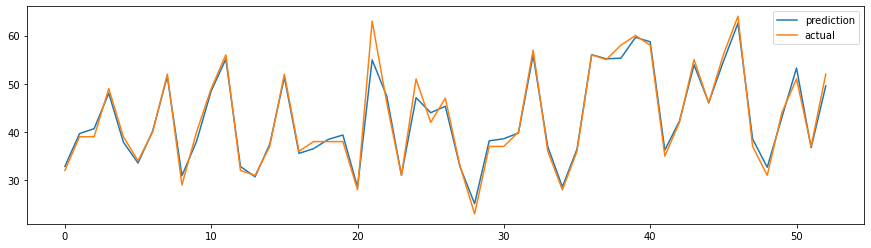

In [141]:
plt.figure(figsize= (15, 4))
plt.plot(cut_model.predict(X_test_cut), label = "prediction")
plt.plot(y_test_cut, label = "actual")
plt.legend();

# Predict on new data

## Read in most recent dataset

In [320]:
url = "https://www.internetwache-polizei-berlin.de/vdb/Fahrraddiebstahl.csv"
download = requests.get(url)
decoded_content = download.content.decode('ISO-8859-1')
file = decoded_content.splitlines()

# cr = csv.reader(file, delimiter=',')
cr = csv.DictReader(file, delimiter=',')
my_list = list(cr)
df_new = pd.DataFrame(my_list)

In [321]:
df_new.head()

,ANGELEGT_AM,TATZEIT_ANFANG_DATUM,TATZEIT_ANFANG_STUNDE,TATZEIT_ENDE_DATUM,TATZEIT_ENDE_STUNDE,LOR,SCHADENSHOEHE,VERSUCH,ART_DES_FAHRRADS,DELIKT,ERFASSUNGSGRUND
0,06.03.2022,06.03.2022,07,06.03.2022,09,02200211,900,Nein,Fahrrad,Fahrraddiebstahl,Sonstiger schwerer Diebstahl von Fahrrädern
1,06.03.2022,06.03.2022,13,06.03.2022,22,07300619,799,Nein,Herrenfahrrad,Fahrraddiebstahl,Sonstiger schwerer Diebstahl von Fahrrädern
2,06.03.2022,05.03.2022,14,06.03.2022,14,07200413,789,Nein,Herrenfahrrad,Fahrraddiebstahl,Sonstiger schwerer Diebstahl von Fahrrädern
3,06.03.2022,05.03.2022,11,06.03.2022,18,07200413,650,Nein,Damenfahrrad,Fahrraddiebstahl,Sonstiger schwerer Diebstahl von Fahrrädern
4,06.03.2022,05.03.2022,16,06.03.2022,15,03701660,2035,Nein,Damenfahrrad,Fahrraddiebstahl,Sonstiger schwerer Diebstahl von Fahrrädern


In [322]:
eng_col_names = [
    "date_reported",
    "date_theft_start",
    "hour_theft_start",
    "date_theft_end",
    "hour_theft_end",
    "LOR",
    "estimated_value",
    "attempt",
    "type_bike", 
    "theft_type",
    "theft_type_detail"    
]
df_new.columns = eng_col_names

In [323]:
df_new.dtypes

date_reported        object
date_theft_start     object
hour_theft_start     object
date_theft_end       object
hour_theft_end       object
LOR                  object
estimated_value      object
attempt              object
type_bike            object
theft_type           object
theft_type_detail    object
dtype: object

In [324]:
df_new["date_theft_start"] =  pd.to_datetime(df_new["date_theft_start"], format='%d.%m.%Y')

In [325]:
df_new.dtypes

date_reported                object
date_theft_start     datetime64[ns]
hour_theft_start             object
date_theft_end               object
hour_theft_end               object
LOR                          object
estimated_value              object
attempt                      object
type_bike                    object
theft_type                   object
theft_type_detail            object
dtype: object

In [326]:
# Group dataframe by date and LOR
df_new = df_new.pivot_table(index = "date_theft_start", values = "type_bike", aggfunc= "count")

df_new.fillna(value = 0, inplace=True)

In [327]:
df_new = df_new.rename(columns={"type_bike": "total"})

## Create input array for the prediction

Steps: 
- remove the last three days of df_new
- add rolling average to df_new
- create input array for prediction out of df_new
- use the cut_model (that was not re-trained on the df_new) to predict on the input array

In [328]:
# remove last three days of df_new
print(df_new.shape)
df_new = df_new[:-3]
df_new.shape

(430, 1)


(427, 1)

In [329]:
# add rolling average
df_new = calculate_rolling_average(df_new, 3)

In [330]:
# create input array
pred_array = np.array(df_new[-31-1:-1])
pred_array = np.expand_dims(pred_array, 0)
pred_array.shape

(1, 31, 2)

In [331]:
# predict on that array using cut_model
cut_model.predict(pred_array)

array([[25.240082]], dtype=float32)

In [332]:
# compare with actual value
df_new.total[-1]

24

# Feature Selection

In [486]:
df_combined.head()

,the_temp,wind_speed,air_pressure,humidity,visibility,daylight_hours,isholidays,weekday,weeknum,total
date,,,,,,,,,,
2021-01-01,2.070,3.020726,1007.0,93,6.031650,7.840000,1,4,53,16.0
2021-01-02,2.465,2.666541,1015.0,89,12.863316,7.861389,0,5,53,16.0
2021-01-03,0.985,9.161659,1015.0,96,2.144352,7.884722,0,6,53,17.0
2021-01-04,1.355,6.271227,1017.0,96,2.927901,7.909167,0,0,1,33.0
2021-01-05,1.270,6.009528,1017.0,94,7.021805,7.935556,0,1,1,29.0


## Check for correlation of added features

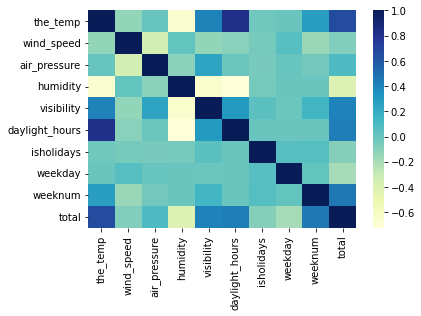

In [487]:
corr = df_combined.corr()
sns.heatmap(corr, 
           xticklabels= corr.columns, 
           yticklabels=corr.columns, 
           cmap = "YlGnBu");

In [488]:
corr_df = corr.unstack().reset_index() # Unstack correlation matrix 

corr_df.columns = ['feature_1','feature_2', 'correlation'] # rename columns

corr_df.sort_values(by="correlation",ascending=False, inplace=True) # sort by correlation

corr_df = corr_df[corr_df['feature_1'] != corr_df['feature_2']] # Remove self correlation

corr_df.head()

,feature_1,feature_2,correlation
5,the_temp,daylight_hours,0.818590
50,daylight_hours,the_temp,0.818590
9,the_temp,total,0.662904
90,total,the_temp,0.662904
98,total,weeknum,0.454499


In [489]:
# drop daylight_hours as it is highly correlated with the_temp
df_combined.drop(columns=["daylight_hours"], inplace = True)

In [492]:
# Compute rolling average
df_combined = calculate_rolling_average(df_combined, 3)

/tmp/ipykernel_4484/4049225974.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["total_moving_average"] = df["total"].rolling(window = window_size, center = True).mean().fillna(fill_value)


## Change weekday to isweekend

In [496]:
di = {0: 0, 1: 0, 2: 0, 3: 0, 4: 0, 5: 1, 6: 1}
df_combined.weekday = df_combined.weekday.map(di)

/tmp/ipykernel_4484/4261972927.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_combined.weekday = df_combined.weekday.map(di)


In [497]:
df_combined.rename(columns= {"weekday": "isweekend"}, inplace = True)

/tmp/ipykernel_4484/21711443.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_combined.rename(columns= {"weekday": "isweekend"}, inplace = True)


In [498]:
df_combined.tail()

,the_temp,wind_speed,air_pressure,humidity,visibility,isholidays,isweekend,weeknum,total,total_moving_average
date,,,,,,,,,,
2022-02-21,6.060,16.053397,994.0,72,12.985726,0,0,8,44.0,42.000000
2022-02-22,6.145,11.185084,1012.5,73,12.052116,0,0,8,51.0,44.000000
2022-02-23,8.520,11.603206,1021.5,69,12.769178,0,0,8,37.0,46.666667
2022-02-24,9.210,9.855780,1011.5,67,14.118175,0,0,8,52.0,43.666667
2022-02-25,6.305,11.460817,1016.0,64,10.139846,0,0,8,42.0,43.666667


## Comparison model with all features

In [506]:
feat_model = create_opt_model()

In [508]:
len_ = int((len(df_combined[:-3])) * 0.8)
X_train_feat, y_train_feat = get_X_y(31,1, df_combined.iloc[:len_, :])
X_test_feat, y_test_feat = get_X_y(31, 1, df_combined.iloc[len_:-3, :])

In [509]:
cv_results = model_cross_validation(feat_model, X_train_feat, y_train_feat)

2/2 [==============================] - 0s 7ms/step - loss: 153.7454 - mean_absolute_percentage_error: 15.8969


In [512]:
np.mean(cv_results, axis = 0)[1]

22.23086757659912

In [510]:
# evaluate model on test data
test_result = feat_model.evaluate(X_test_feat, y_test_feat)[1]

2/2 [==============================] - 0s 8ms/step - loss: 152.4709 - mean_absolute_percentage_error: 28.8359


## Feature permutation

In [491]:
# Remove the last three observations
df_combined = df_combined[:-3]

We check the influence of "the_temp", "isweekend" and "weeknum" on the overall fit.

Steps: 
- create empty optimal model
- drop one of the features
- do a 5-Fold-cross-validation on that dataframe
- compare the results

In [499]:
# First create a dataframe that only has the necessary features
df_combined = df_combined[["the_temp", "isweekend", "weeknum", "total", "total_moving_average"]]

In [500]:
df_combined.head()

,the_temp,isweekend,weeknum,total,total_moving_average
date,,,,,
2021-01-01,2.070,0,53,16.0,43.666667
2021-01-02,2.465,1,53,16.0,16.333333
2021-01-03,0.985,1,53,17.0,22.000000
2021-01-04,1.355,0,1,33.0,26.333333
2021-01-05,1.270,0,1,29.0,33.000000


In [501]:
df_combined.columns

Index(['the_temp', 'isweekend', 'weeknum', 'total', 'total_moving_average'], dtype='object')

In [502]:
feats = list(df_combined.columns)
feats.remove("total")
feats

['the_temp', 'isweekend', 'weeknum', 'total_moving_average']

In [504]:
feat_dict = {}
for feature in feats: 
    feat_list = []
    # instantiate empty model
    model = create_opt_model()
    # drop one of the features 
    df = df_combined.drop(columns = [feature])
    # create training and test arrays
    len_ = int((len(df[:-3])) * 0.8)
    X_train, y_train = get_X_y(31,1, df.iloc[:len_, :])
    X_test, y_test = get_X_y(31, 1, df.iloc[len_:-3, :])
    #5 Fold cross validation
    cv_results = model_cross_validation(model, X_train, y_train)
    
    # evaluate model on test data
    test_result = model.evaluate(X_test, y_test)[1]
    # save output of cross validation
    feat_dict[feature] = {"CV result": np.mean(cv_results, axis = 0)[1], 
                          "Test result": test_result}
    

2/2 [==============================] - 0s 8ms/step - loss: 259.5283 - mean_absolute_percentage_error: 33.2705


In [505]:
pd.DataFrame(feat_dict)

,the_temp,isweekend,weeknum,total_moving_average
CV result,13.315907,12.645178,36.252948,34.310630
Test result,6.446708,13.071792,56.349522,33.270508


From the feature permutation it seems that dropping "the_temp" and "isweekend" increases MAPE. 

## Run model with features "total_moving_average" and "weeknum"

In [514]:
added_feat_model = create_opt_model()

In [515]:
df_combined = df_combined[["total", "total_moving_average", "weeknum"]]

In [516]:
df_combined.head()

,total,total_moving_average,weeknum
date,,,
2021-01-01,16.0,43.666667,53
2021-01-02,16.0,16.333333,53
2021-01-03,17.0,22.000000,53
2021-01-04,33.0,26.333333,1
2021-01-05,29.0,33.000000,1


In [517]:
len_ = int((len(df_combined[:-3])) * 0.8)
X_train_feat, y_train_feat = get_X_y(31,1, df_combined.iloc[:len_, :])
X_test_feat, y_test_feat = get_X_y(31, 1, df_combined.iloc[len_:-3, :])

In [518]:
cv_results = model_cross_validation(added_feat_model, X_train_feat, y_train_feat)

2/2 [==============================] - 0s 8ms/step - loss: 62.2069 - mean_absolute_percentage_error: 10.3376


In [519]:
np.mean(cv_results, axis = 0)[1]

16.35210256576538

In [520]:
# evaluate model on test data
test_result = added_feat_model.evaluate(X_test_feat, y_test_feat)[1]

2/2 [==============================] - 0s 6ms/step - loss: 17.1255 - mean_absolute_percentage_error: 8.9108
